In [ ]:
from google.colab import drive

drive.mount("/gdrive")

In [2]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Paths to the training images and labels pickled files
train_images_path = r"/gdrive/MyDrive/Colab Notebooks/636_project1_train_images"
train_labels_path = r"/gdrive/MyDrive/Colab Notebooks/636_project1_train_labels"

# Load the training images and labels from the pickled files
train_images = pickle.load(open(train_images_path, "rb"))
train_labels = pickle.load(open(train_labels_path, "rb"))

# Reshape the training images to have shape (num_samples, 28, 28, 1)
# Here, len(train_images) represents the number of samples
train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))

# Normalize the pixel values to be between 0 and 1
train_images = train_images.astype("float32") / 255.0

# Convert the labels to a NumPy array
train_labels = np.array(train_labels)

# Print the shapes of the training images and labels to verify
print("train_images shape:", train_images.shape)
print("train_labels shape", train_labels.shape)

train_images shape: (60000, 28, 28, 1)
train_labels shape (60000,)


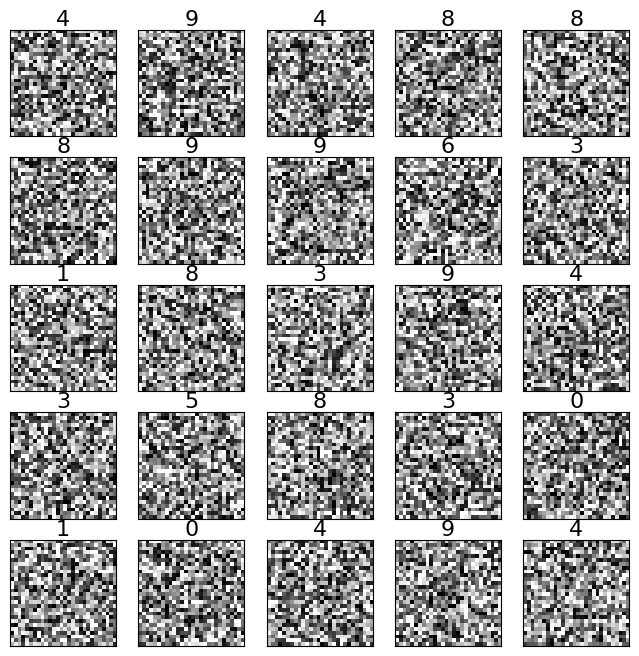

In [4]:
# Generate a random permutation of indices
indices = np.random.permutation(len(train_labels))

plt.figure(figsize=(8, 8))

# Loop to display 25 random images and their corresponding labels
for i in range(25):
    idx = indices[i]
    plt.subplot(5, 5, i + 1)
    plt.title(str(train_labels[idx]), fontsize=16, color="black", pad=2)
    plt.imshow(train_images[idx].reshape(28, 28), cmap=plt.cm.binary)

    plt.xticks([])
    plt.yticks([])

plt.show()

In [5]:
# Ensure train_images and train_labels are numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Shuffle the training images and labels to ensure random distribution
train_images, train_labels = utils.shuffle(train_images, train_labels)

# Assign the shuffled training images and labels to X_train and y_train
X_train = train_images  # [0:50000]
y_train = train_labels  # [0:50000]

# X_test = train_images[50000:60000]
# y_test = train_labels[50000:60000]

In [6]:
def get_model():
    input_img = keras.Input(shape=(28, 28, 1))

    # First convolutional layer with 16 filters, kernel size 3x3, ReLU activation, and same padding
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
    # Max pooling layer with pool size 2x2 and same padding
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Second convolutional layer with 32 filters, kernel size 3x3, no bias, and same padding
    x = layers.Conv2D(32, (3, 3), use_bias=False, padding="same")(x)
    # Batch normalization and ReLU activation
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Max pooling layer with pool size 2x2 and same padding
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    # Dropout layer with a dropout rate of 0.4
    x = layers.Dropout(0.4)(x)

    # Save the current state of the network to a residual connection
    residual = x

    # Third convolutional layer with 64 filters, kernel size 3x3, no bias, and same padding
    x = layers.Conv2D(64, (3, 3), use_bias=False, padding="same")(x)
    # Batch normalization and ReLU activation
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Max pooling layer with pool size 2x2 and same padding
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    # Dropout layer with a dropout rate of 0.4
    x = layers.Dropout(0.4)(x)

    # Adjust the residual connection to match the shape of the main path
    residual = layers.Conv2D(64, 1, strides=2)(residual)
    # Add the residual connection to the main path
    x = layers.add([x, residual])

    # Dropout layer with a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Fourth convolutional layer with 128 filters, kernel size 3x3, ReLU activation, and same padding
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    # Flatten the output to prepare it for the dense layer
    x = layers.Flatten()(x)
    # Dropout layer with a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Dense layer with 10 units and softmax activation for classification
    outputs = layers.Dense(10, activation="softmax")(x)

    # Create the model
    model = keras.Model(input_img, outputs)
    # Compile the model with Adamax optimizer, sparse categorical crossentropy loss, and accuracy metric
    model.compile(
        optimizer="adamax", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [7]:
# Define the path where you want to save the best model
checkpoint_path = "best_model.h5"

# Configure ModelCheckpoint to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
)

model = get_model()
history = model.fit(
    X_train,
    y_train,
    epochs=64,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[checkpoint_callback],
)

Epoch 1/64
1490/1500 [============================>.] - ETA: 0s - loss: 2.3223 - accuracy: 0.1109
Epoch 1: val_accuracy improved from -inf to 0.12308, saving model to best_model.h5
1500/1500 [==============================] - 15s 6ms/step - loss: 2.3222 - accuracy: 0.1108 - val_loss: 2.2967 - val_accuracy: 0.1231
Epoch 2/64
  23/1500 [..............................] - ETA: 6s - loss: 2.3024 - accuracy: 0.1223

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1497/1500 [============================>.] - ETA: 0s - loss: 2.2262 - accuracy: 0.1737
Epoch 2: val_accuracy improved from 0.12308 to 0.25100, saving model to best_model.h5
1500/1500 [==============================] - 12s 8ms/step - loss: 2.2259 - accuracy: 0.1738 - val_loss: 2.0980 - val_accuracy: 0.2510
Epoch 3/64
1497/1500 [============================>.] - ETA: 0s - loss: 2.0556 - accuracy: 0.2639
Epoch 3: val_accuracy improved from 0.25100 to 0.30475, saving model to best_model.h5
1500/1500 [==============================] - 9s 6ms/step - loss: 2.0552 - accuracy: 0.2641 - val_loss: 1.9562 - val_accuracy: 0.3047
Epoch 4/64
1493/1500 [============================>.] - ETA: 0s - loss: 1.7844 - accuracy: 0.3752
Epoch 4: val_accuracy improved from 0.30475 to 0.46125, saving model to best_model.h5
1500/1500 [==============================] - 9s 6ms/step - loss: 1.7837 - accuracy: 0.3756 - val_loss: 1.6215 - val_accuracy: 0.4613
Epoch 5/64
1495/1500 [============================>.] - ETA

In [8]:
model = load_model("best_model.h5")

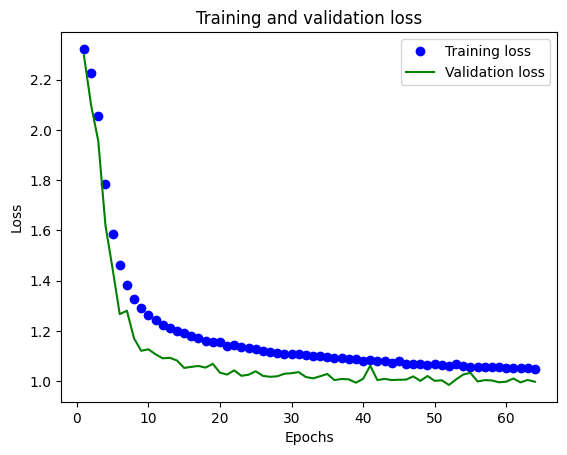

In [9]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "g", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

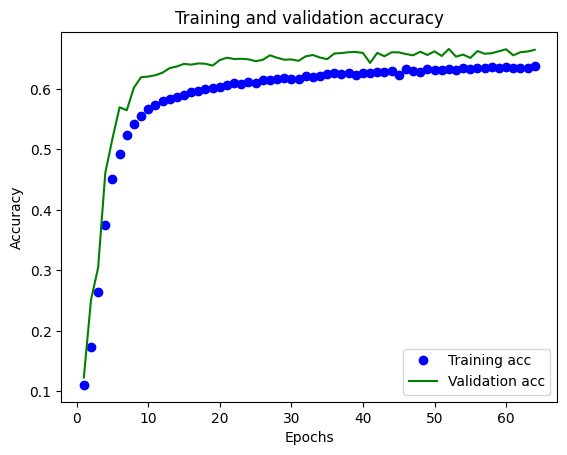

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "g", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [11]:
# test_loss, test_acc = model.evaluate(X_test, y_test)